<a href="https://colab.research.google.com/github/Gabril0/CNN/blob/main/Attention_UNET_Oral_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary of the model studied
The model studied focus mainly in providing an U-NET with a good and robust data augmentation to avoid pitfalls and enhance the learning capabilities.

In [1]:
#downloading the dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip

--2024-03-07 13:41:24--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.1.162, 3.5.65.25, 52.218.96.243, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.1.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1081025712 (1.0G) [application/zip]
Saving to: ‘9bsc36jyrt-1.zip’

9bsc36jyrt-1.zip    100%[===================>]   1.01G  27.4MB/s    in 39s     

2024-03-07 13:42:03 (26.7 MB/s) - ‘9bsc36jyrt-1.zip’ saved [1081025712/1081025712]



In [2]:
#imports
import os
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose,Cropping2D, Concatenate, Activation, BatchNormalization
from keras import Model

In [3]:
#unzipping
!unzip /content/9bsc36jyrt-1.zip
!rm -r "/content/9bsc36jyrt-1.zip"
clear_output()

In [4]:
#getting path references
#training used only the roi folders

testing_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009009/01-roi"
testing_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009010x1000902/01-roi"
testing_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009011/01-roi"
testing_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009014/01-roi"
testing_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009016x1000903/01-roi"
testing_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009023/01-roi"

training_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009009/01-roi"
training_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009010x1000902/01-roi"
training_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009011/01-roi"
training_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009014/01-roi"
training_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009016x1000903/01-roi"
training_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009023/01-roi"

training_folders = [training_folder1, training_folder2, training_folder3, training_folder4, training_folder5, training_folder6]
#the mask folders will be added dinamically
testing_folders = [testing_folder1, testing_folder2, testing_folder3, testing_folder4, testing_folder5, testing_folder6]

training_path = []
mask_path = []
test_path = []
test_mask_path = []


def append_paths(folder, pathList, complementaryPath):
    full_path = os.path.join(folder, complementaryPath)
    if os.path.isdir(full_path):
        for file in os.listdir(full_path):
            if file.endswith(".png"):
                pathList.append(os.path.join(full_path, file))
            else:
                print("error in file " + file)
    else:
        print("error: " + full_path + " could not be found")

for folder in training_folders: #appending the paths for the original images and respective masks
  append_paths(folder,training_path,"01-original")
  append_paths(folder,mask_path,"02-mask")

for folder in testing_folders: #appending the paths for the test images
  append_paths(folder,test_path,"01-original")
  append_paths(folder,test_mask_path,"02-mask")


In [5]:
#transforming into numpy array

width = 256
height = 256

def path_to_array(path, numpyArray):
  for file in path:
    image = plt.imread(file)
    image_array = np.array(image)
    resized_image = cv2.resize(image_array, (width,height))
    numpyArray.append(resized_image)

training_array = []
mask_array = []
test_array = []
test_mask_array = []

path_to_array(training_path, training_array)
path_to_array(mask_path, mask_array)
path_to_array(test_path, test_array)
path_to_array(test_mask_path, test_mask_array)


In [6]:
print(len(training_array))

361


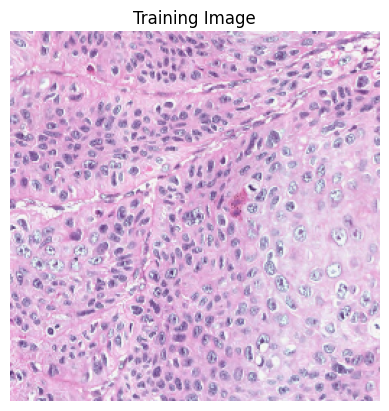

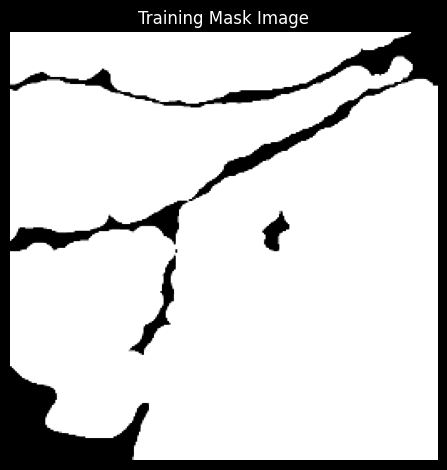

In [7]:
#showing an image
plt.imshow(training_array[5])
plt.title('Training Image')
plt.axis('off')

plt.figure(facecolor='black')
plt.imshow(mask_array[5])
plt.title('Training Mask Image',color="white")
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
#data augmentation
#do data augmentation horizontal flip, vertical flip, rotation, transpose, grid distortion,
#optical distortion, color transfer, inpainting

def flip_horizontal(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        aug_image = np.flip(image, axis=1)
        aug_mask = np.flip(mask, axis=1)

        aug_images.append(aug_image)
        aug_masks.append(aug_mask)

    return aug_images, aug_masks


def flip_vertical(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        aug_image = np.flip(image, axis=0)
        aug_mask = np.flip(mask, axis=0)

        aug_images.append(aug_image)
        aug_masks.append(aug_mask)

    return aug_images, aug_masks


def random_rotation(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        angle = random.uniform(0, 360)

        height, width = image.shape[:2]

        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
        rotated_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))

        aug_images.append(rotated_image)
        aug_masks.append(rotated_mask)

    return aug_images, aug_masks


def grid_distort(image_array, mask_array, rows=10, cols=10):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        distort_grid = np.indices(image.shape[:2], dtype=np.float32)
        distort_grid += np.random.normal(size=distort_grid.shape) * 10

        distort_grid[0] = np.clip(distort_grid[0], 0, image.shape[0] - 1)
        distort_grid[1] = np.clip(distort_grid[1], 0, image.shape[1] - 1)

        map_x = distort_grid[1]
        map_y = distort_grid[0]

        distorted_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
        distorted_mask = cv2.remap(mask, map_x, map_y, cv2.INTER_LINEAR)

        aug_images.append(distorted_image)
        aug_masks.append(distorted_mask)

    return aug_images, aug_masks

augmented_images, augmented_masks = flip_horizontal(training_array, mask_array)
augmented_images.extend(flip_vertical(training_array, mask_array)[0])
augmented_masks.extend(flip_vertical(training_array, mask_array)[1])
augmented_images.extend(random_rotation(training_array, mask_array)[0])
augmented_masks.extend(random_rotation(training_array, mask_array)[1])
augmented_images.extend(grid_distort(training_array, mask_array)[0])
augmented_masks.extend(grid_distort(training_array, mask_array)[1])


In [9]:
print(len(augmented_images))
print(len(augmented_masks))

1444
1444


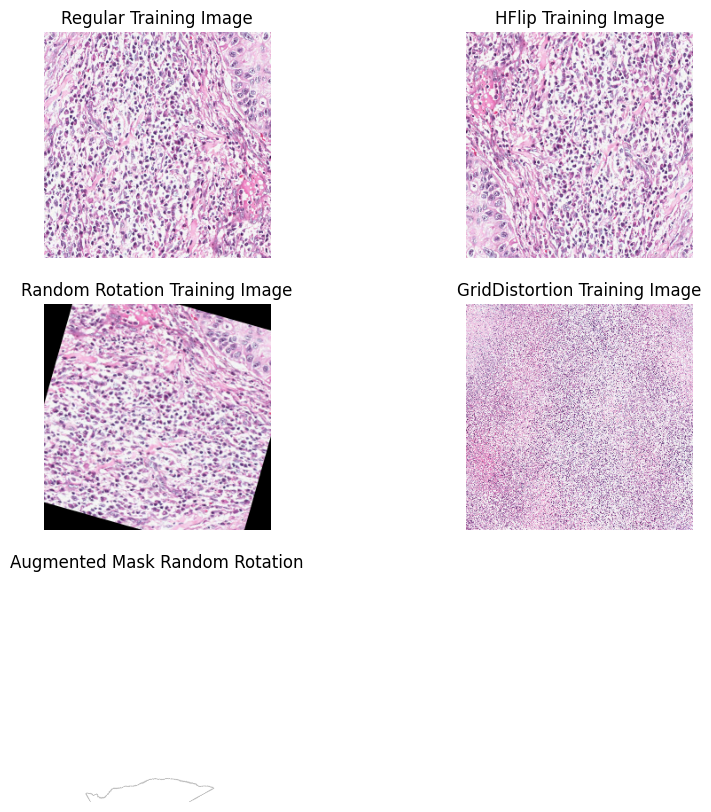

In [10]:
#showing data aug results
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(3, 2, 1)
plt.imshow(augmented_images[1])
plt.title('Regular Training Image')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(augmented_images[362])
plt.title('HFlip Training Image')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(augmented_images[723])
plt.title('Random Rotation Training Image')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(augmented_images[1084])
plt.title('GridDistortion Training Image')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(augmented_masks[723])
plt.title('Augmented Mask Random Rotation')
plt.axis('off')

plt.show()

In [11]:
#constructing the UNET functions

def conv_block(inputs,filters):
  #two conv layers with batch normalization and relu, this makes features more apparent as the tiny weight get smaller and big ones grow
  conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return conv

def attention_gate(input_tensor, skip_tensor, filters):
  #relu
  attn = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(input_tensor)
  attn = BatchNormalization()(attn)
  attn = Activation('relu')(attn)

  #sigmoid
  attn = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(attn)
  attn = BatchNormalization()(attn)
  attn = Activation('sigmoid')(attn)

  #resampler
  attn = UpSampling2D(size=(2, 2))(attn)
  attn = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(attn)

  #multiplication with the skip_tensor layer
  multiplied = tf.multiply(skip_tensor, attn)

  concatenated = Concatenate()([input_tensor, multiplied])
  return concatenated




def unet_build(input_shape):
  inputs = Input(input_shape)

  #downsampling
  conv1 = conv_block(inputs, 64)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = conv_block(pool1, 128)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = conv_block(pool2, 256)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = conv_block(pool3, 512)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  #bridge
  conv5 = conv_block(pool4, 1024)

  #upsampling
  up6 = UpSampling2D(size=(2, 2))(conv5)
  up6 = attention_gate(up6, conv4, 512)
  conv6 = conv_block(up6, 512)

  up7 = UpSampling2D(size=(2, 2))(conv6)
  up7 = attention_gate(up7, conv3, 256)
  conv7 = conv_block(up7, 256)

  up8 = UpSampling2D(size=(2, 2))(conv7)
  up8 = attention_gate(up8, conv2, 128)
  conv8 = conv_block(up8, 128)

  up9 = UpSampling2D(size=(2, 2))(conv8)
  up9 = attention_gate(up9, conv1, 64)
  conv9 = conv_block(up9, 64)

  outputs = Conv2D(4, kernel_size=(1, 1), strides=(1, 1), activation='softmax')(conv9)

  model = Model(inputs=inputs, outputs=outputs)
  return model


In [12]:
#creation of the network
input_shape = (width, height, 3)
model = unet_build(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [13]:
#training
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


#test_images = np.squeeze(test_images)
#test_masks = np.squeeze(test_masks)
#print("Updated Test images shape:", test_images.shape)
#print("Updated Test masks shape:", test_masks.shape)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
test_array = np.array(test_array)
test_mask_array = np.array(test_mask_array)

history = model.fit(augmented_images,
                    augmented_masks,
                    validation_data=(test_array, test_mask_array),
                    epochs=15,
                    batch_size=8)

Epoch 1/15
181/181 [==============================] - 199s 842ms/step - loss: 0.5702 - accuracy: 0.2112 - val_loss: 1.2048 - val_accuracy: 0.0214
Epoch 2/15
181/181 [==============================] - 128s 709ms/step - loss: 0.5146 - accuracy: 0.2692 - val_loss: 1.4875 - val_accuracy: 0.4984
Epoch 3/15
181/181 [==============================] - 129s 712ms/step - loss: 0.5042 - accuracy: 0.3065 - val_loss: 2.8760 - val_accuracy: 0.0433
Epoch 4/15
181/181 [==============================] - 129s 714ms/step - loss: 0.4957 - accuracy: 0.2943 - val_loss: 2.0763 - val_accuracy: 0.1441
Epoch 5/15
181/181 [==============================] - 129s 710ms/step - loss: 0.4872 - accuracy: 0.2819 - val_loss: 0.5511 - val_accuracy: 0.4805
Epoch 6/15
181/181 [==============================] - 130s 716ms/step - loss: 0.4761 - accuracy: 0.2719 - val_loss: 1.1607 - val_accuracy: 0.2735
Epoch 7/15
181/181 [==============================] - 129s 712ms/step - loss: 0.4707 - accuracy: 0.2759 - val_loss: 0.3766 -

In [15]:
#evaluate the model
loss, accuracy = model.evaluate(test_array, test_mask_array)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

NameError: name 'test_images' is not defined

1/1 [==============================] - 4s 4s/step


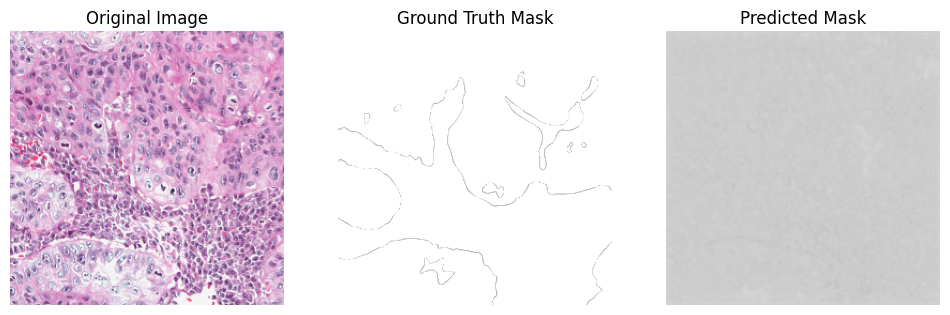

In [16]:
#testing
import matplotlib.pyplot as plt

image_index = 4
test_image = test_array[image_index]
test_mask = test_mask_array[image_index]

test_image = np.expand_dims(test_image, axis=0)

predicted_mask = model.predict(test_image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Predicted Mask')

plt.show()

In [ ]:
#analytics

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
#do accuracy, precision, F1, IOU, Sensitivity, Specificity